In [1]:

%pprint
import sys
sys.path.insert(1, '../py')

Pretty printing has been turned OFF


In [2]:

import os
from pandas import DataFrame
import pandas as pd
from notebook_utils import NotebookUtilities
import matplotlib.pyplot as plt
import re
import humanize

nu = NotebookUtilities(data_folder_path=os.path.abspath('../data'))

In [3]:

# Get all CSVs into one data frame
if nu.pickle_exists('frvrs_logs_df'):
    frvrs_logs_df = nu.load_object('frvrs_logs_df')
    print(frvrs_logs_df.shape)
    # df = frvrs_logs_df.sample(4).dropna(axis='columns', how='all')
    # display(df.T)

(168528, 109)



# Number of Patients Treated

In [4]:

# Number of patients treated
# Initialize an empty list to store data for each session group
rows_list = []

# Iterate over the grouped dataframe
for (session_uuid, time_group), df1 in nu.get_session_groupby(extra_column='time_group'):

    # Get the logger version
    logger_version = df1.logger_version.unique().item()

    # Count the number of unique patients in the current group
    patients_count = len(df1.patient_id.unique())
    
    # Initialize a counter for patients treated in the current group
    patients_treated = 0
    
    # Iterate over the patients in the group
    for patient_id, df2 in df1.groupby('patient_id'):

        # Create a mask to filter rows where action_type is 'INJURY_TREATED'
        mask_series = (df2.action_type == 'INJURY_TREATED')
        
        # Check if any rows satisfy the mask, increment the number of patients treated
        if df2[mask_series].shape[0]: patients_treated += 1

    # Check if there are any patients in the current group
    if patients_count:

        # Create a dictionary to store information about the current session group
        row_dict = {}

        # Add the logger version to the dictionary
        row_dict['logger_version'] = logger_version

        # Add the session_uuid to the dictionary
        row_dict['session_uuid'] = session_uuid

        # Add the time_group to the dictionary
        row_dict['time_group'] = time_group

        # Add the number of patients in the group to the dictionary
        row_dict['patients_count'] = patients_count

        # Add the number of patients treated to the dictionary
        row_dict['patients_treated'] = patients_treated

        # Calculate and add the percentage of patients treated to the dictionary
        row_dict['percentage_treated'] = patients_treated / patients_count

        # Add the row dictionary to the list of rows
        rows_list.append(row_dict)

# Create a data frame from the list of rows
percentage_treated_df = DataFrame(rows_list)

In [5]:

percentage_treated_df.sort_values('percentage_treated')

,logger_version,session_uuid,time_group,patients_count,patients_treated,percentage_treated
0,1.0,04882754-51a0-4e5b-9617-b200e3609116,0,4,0,0.0
119,1.0,51f8d40c-9550-4ef1-a71c-e030c0a08f29,0,4,0,0.0
251,1.0,992d4672-7993-44ba-890c-0d8605ccefdd,0,3,0,0.0
248,1.0,97401484-055e-4590-9a11-7d911c42564b,0,4,0,0.0
122,1.0,524d5418-62f4-4834-9f1e-47202c30e667,0,4,0,0.0
...,...,...,...,...,...,...
245,1.0,93d6665a-9210-4bb9-b084-69d6e7335d04,1,5,4,0.8
6,1.0,06574b6f-ab02-432c-9a65-7b031218a270,3,5,4,0.8
81,1.0,3817ac9f-7150-46de-80aa-1b376f6c8a62,1,5,4,0.8
398,1.0,e9632b3b-77f2-4f62-a778-5d6a4242aa3b,1,5,4,0.8


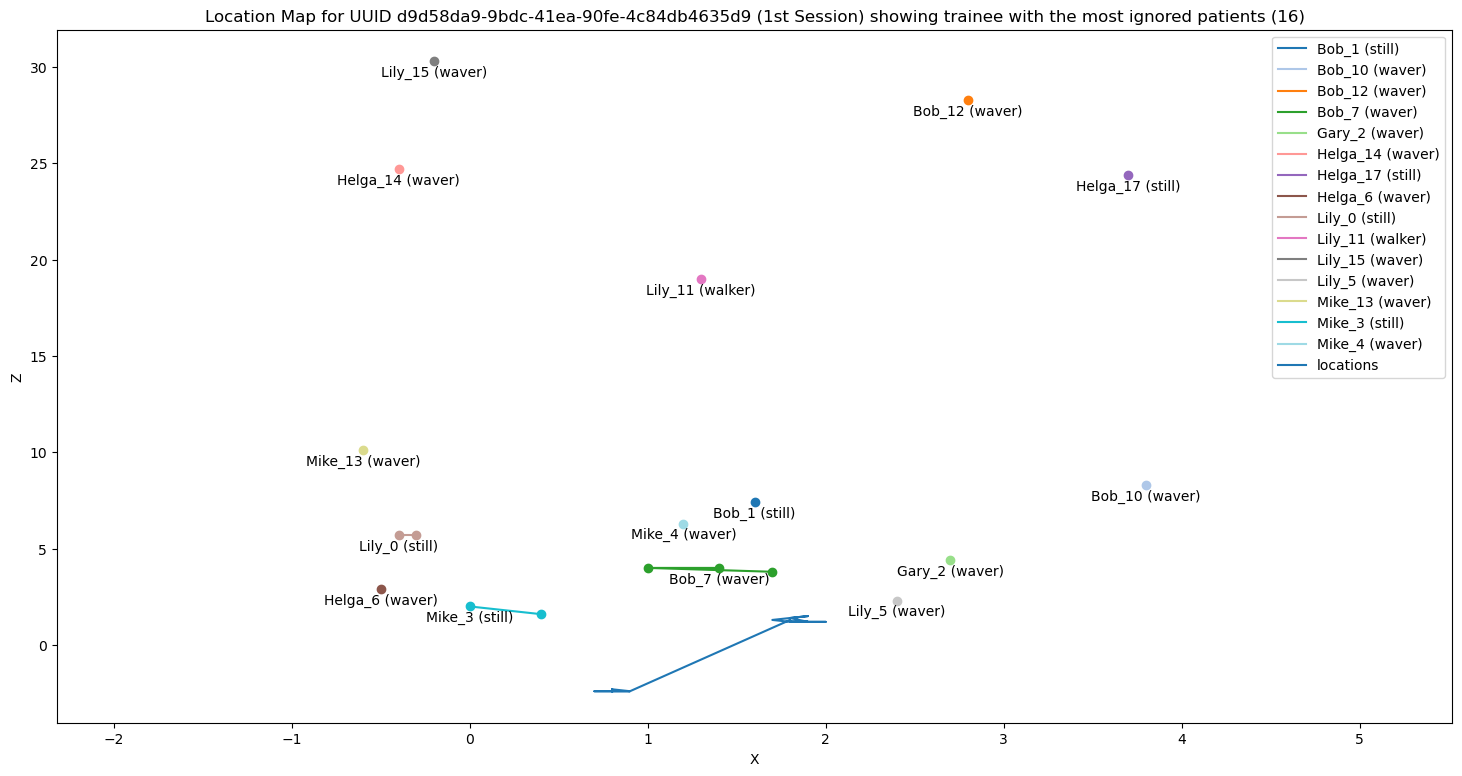

In [10]:

# Get time group with the most ignored patients, v1.3
mask_series = (percentage_treated_df.percentage_treated == 0) & (percentage_treated_df.logger_version == 1.3)
nu.visualize_extreme_player_movement(
    percentage_treated_df, 'patients_count', mask_series=mask_series, is_ascending=False, humanize_type='intword',
    title_str='most ignored patients', frvrs_logs_df=None, verbose=False
)

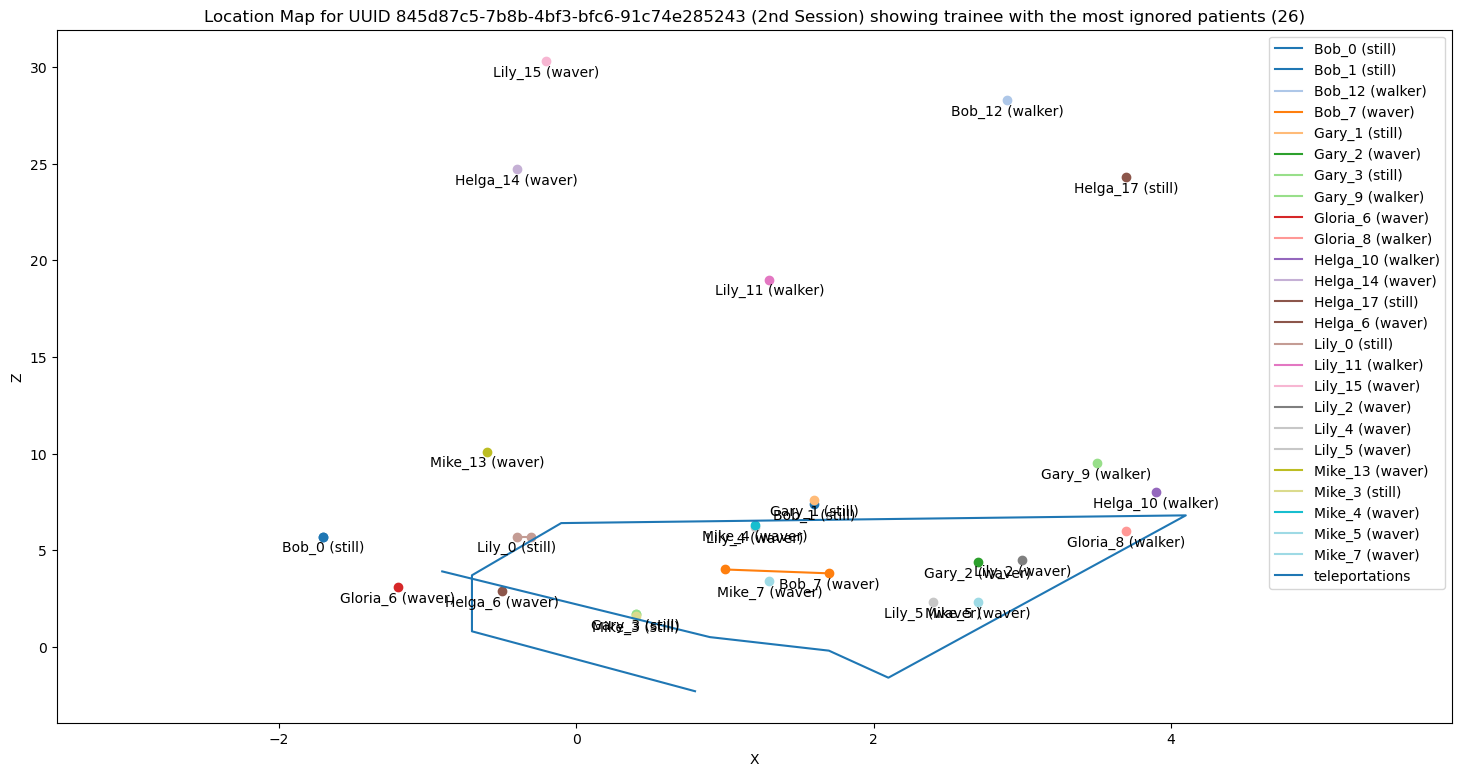

In [9]:

# Get time group with the most ignored patients, v1.0
mask_series = (percentage_treated_df.percentage_treated == 0) & (percentage_treated_df.logger_version == 1.0)
nu.visualize_extreme_player_movement(
    percentage_treated_df, 'patients_count', mask_series=mask_series, is_ascending=False, humanize_type='intword',
    title_str='most ignored patients', frvrs_logs_df=None, verbose=False
)

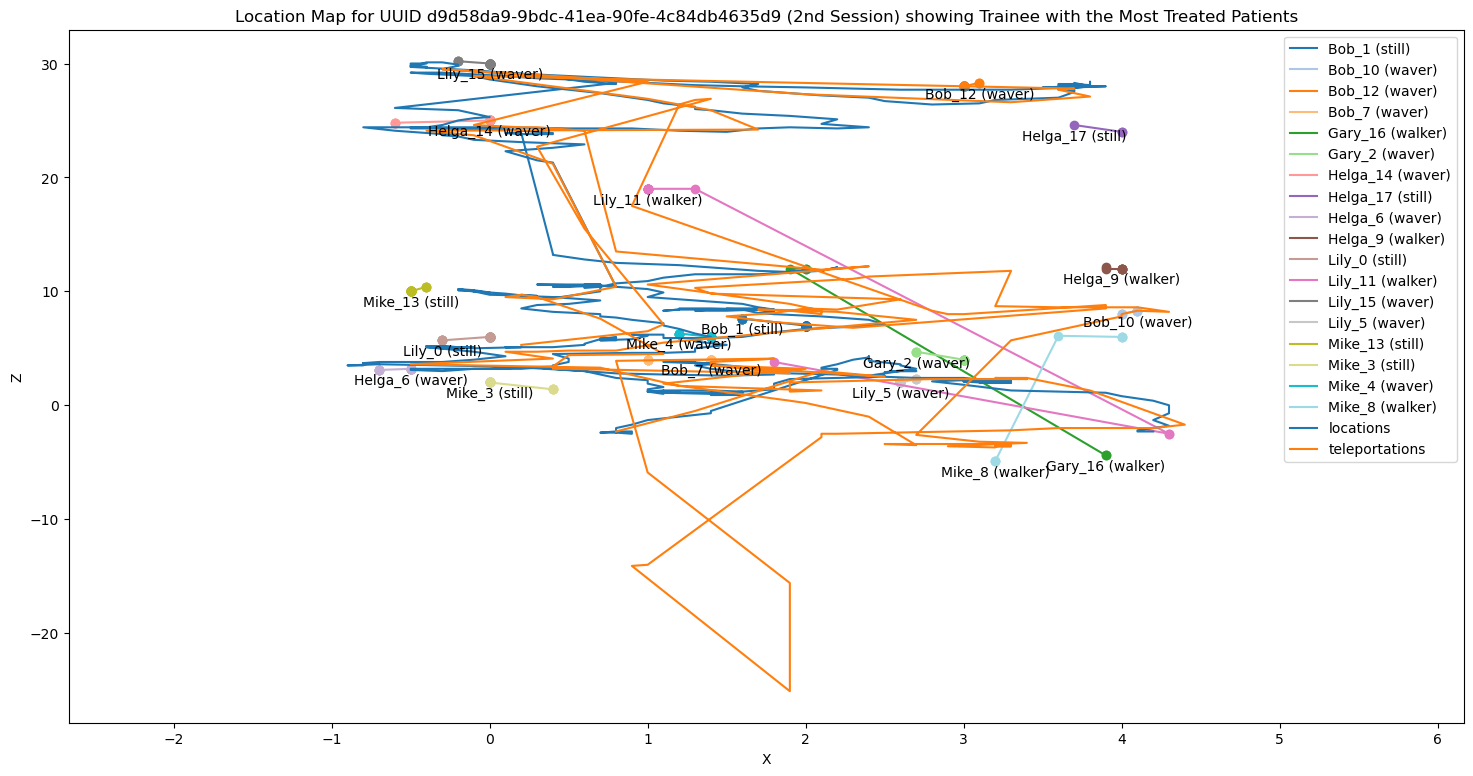

In [12]:

# Get time group with the least ignored patients, v1.3
mask_series = (percentage_treated_df.logger_version == 1.3)
df = percentage_treated_df[mask_series].sort_values(['percentage_treated', 'patients_count']).tail(1)
patients_session_uuid = df.session_uuid.squeeze()
patients_time_group = df.time_group.squeeze()
base_mask_series = (frvrs_logs_df.session_uuid == patients_session_uuid) & (frvrs_logs_df.time_group == patients_time_group)

title = f'Location Map for UUID {patients_session_uuid} ({humanize.ordinal(patients_time_group+1)} Session)'
title += ' showing Trainee with the Most Treated Patients'
nu.visualize_player_movement(base_mask_series, title=title, frvrs_logs_df=frvrs_logs_df)

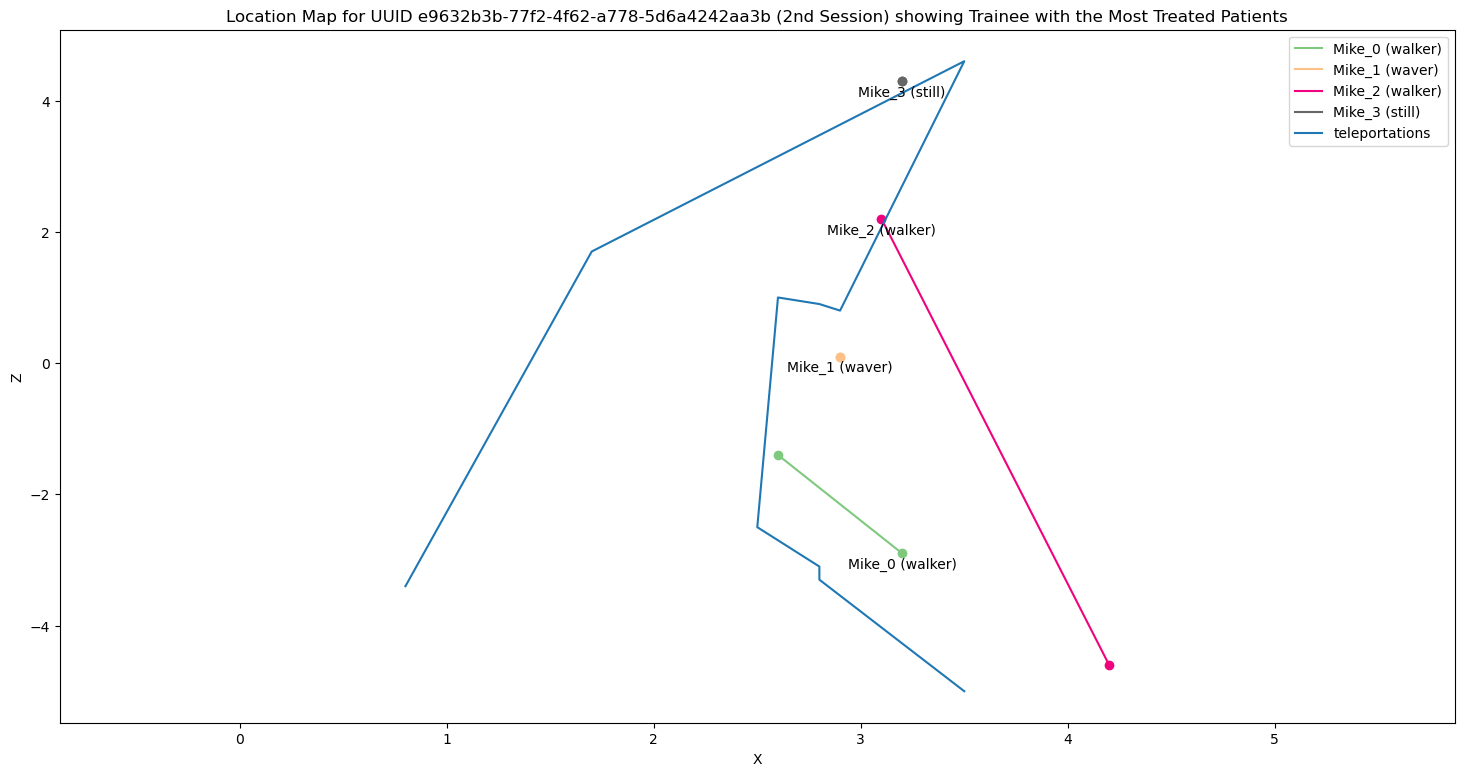

In [10]:

# Get time group with the least ignored patients, v1.0
mask_series = (percentage_treated_df.logger_version == 1.0)
df = percentage_treated_df[mask_series].sort_values(['percentage_treated', 'patients_count']).tail(1)
patients_session_uuid = df.session_uuid.squeeze()
patients_time_group = df.time_group.squeeze()
base_mask_series = (frvrs_logs_df.session_uuid == patients_session_uuid) & (frvrs_logs_df.time_group == patients_time_group)

title = f'Location Map for UUID {patients_session_uuid} ({humanize.ordinal(patients_time_group+1)} Session)'
title += ' showing Trainee with the Most Treated Patients'
nu.visualize_player_movement(base_mask_series, title=title, frvrs_logs_df=frvrs_logs_df)